# Programming task: MDS

## Data acquisition and processing

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
from matplotlib.colors import ListedColormap

In [28]:
# 读取数据并删除第一行
data = pd.read_excel('vote_dataset/EP6_RCVs_2022_06_13.xlsx', header=1).drop(0)
# data.iloc[:, 10:] = data.iloc[:, 10:].fillna(method='bfill')

In [30]:
print(data.head())

   WebisteEpID         Fname      Lname              FullName Activ  \
1      28469.0       Adamos      ADAMOU        ADAMOU, Adamos   yes   
2      28302.0        Filip      ADWENT         ADWENT, Filip    no   
3      28975.0     Vittorio   AGNOLETTO   AGNOLETTO, Vittorio   yes   
4      28367.0     Gabriele   ALBERTINI   ALBERTINI, Gabriele   yes   
5      28512.0   James Hugh    ALLISTER  ALLISTER, James Hugh   yes   

          Country                                              Party  \
1          Cyprus  Anorthotiko Komma Ergazomenou Laou - Aristera ...   
2          Poland                               Liga Polskich Rodzin   
3           Italy  Partito della Rifondazione Comunista - Sinistr...   
4           Italy                                       Forza Italia   
5  United Kingdom                               Traditional Unionist   

                                                 EPG       Start         End  \
1  Confederal Group of the European United Left -...  2004-0

### Defining similarity functions


In [31]:
# 1. Adjust Cosine Similarity

def adjusted_cosine_similarity(vector1,  vector2):
    # Ensure the vectors are numpy arrays
    vector1 = np.array(vector1)
    vector2 = np.array(vector2)

    #vector - mean of the vectors
    vector1_adjusted = vector1 - np.mean(vector1)
    vector2_adjusted = vector2 - np.mean(vector2)

    #公式分子部分
    numerator = np.dot(vector1_adjusted, vector2_adjusted)

    #公式分母部分
    denominator = np.sqrt(np.sum(vector1_adjusted**2)) * np.sqrt(np.sum(vector2_adjusted**2))

    #denominator not equal to 0
    if denominator == 0: 
        return 0
    
    simimarity = numerator / denominator
    return simimarity

In [53]:
# 2. Political position similarity

# 1: support
# 2: against
# 3,5: abstention
# 4,6,0: absent (excluding them)


def PP_similarity(position_dict, vector1,  vector2):
    cnt_valid_votes = 0
    PP_diff = 0

    for vote1, vote2 in zip(vector1, vector2):
        if not position_dict[vote1] or not position_dict[vote2]:
            # this is not effective vote
            continue
        PP_diff += np.abs(position_dict[vote1] - position_dict[vote2])
        cnt_valid_votes += 1
    
    if cnt_valid_votes == 0:
        return 0
    
    # return average political position difference
    return PP_diff / cnt_valid_votes

### Computing similarity matrixs

In [33]:
# 1. Adjust Cosine Similarity matrix

def ACS_coordinatess(data):
    num_rows = data.iloc[:, 10:].shape[0]
    matrix_adjusted_cosine_similarity = np.zeros((num_rows, num_rows))
    #print(len(matrix_adjusted_cosine_similarity), len(matrix_adjusted_cosine_similarity[0]))
    #235 x 235

    means = data.iloc[:, 10:].mean(axis=1).values
    adjusted_data = data.iloc[:, 10:].values - means[:, np.newaxis]

    norms = np.linalg.norm(adjusted_data, axis=1)

    for i in range(num_rows):
        for j in range(i, num_rows): 
            numerator = np.dot(adjusted_data[i], adjusted_data[j])
            denominator = norms[i] * norms[j] 
            similarity = 0 if denominator == 0 else numerator / denominator
            matrix_adjusted_cosine_similarity[i, j] = similarity
            matrix_adjusted_cosine_similarity[j, i] = similarity  

    return matrix_adjusted_cosine_similarity

In [54]:
# 2. Political position Similarity matrix

def PP_sim_matrix(data):
    num_rows = data.shape[0]
    PP_matrix = np.zeros((num_rows, num_rows))
    # 1: support
    # 2: against
    # 3,5: abstention
    # 4,6,0: absent (excluding them)
    # assign value for each kind of position
    position_dict = {
        1: 3,
        2: 1,
        3: 2,
        5: 2,
        4: 0,
        6: 0,
        0: 0
    }
    for i in range(num_rows):
        for j in range(i, num_rows):
            
            PP_sim = PP_similarity(position_dict, data.iloc[i], data.iloc[j])
            print(PP_sim)
            # PP_sim = data.apply(lambda row: PP_similarity(row['A'], row['B']), axis=1)
            PP_matrix[i, j] = PP_sim
            PP_matrix[j, i] = PP_sim
        print(i)
    
    return PP_matrix

## MDS implementing

In [35]:
def c_mds(distance_mat, dim):
    n = distance_mat.shape[0]
    # Create the centering matrix
    H = np.eye(n) - (1/n) * np.ones((n, n))
    
    # Create the B matrix which is the transformed distance matrix
    B = -0.5 * np.dot(H, np.dot(distance_mat**2, H))
    
    # Perform Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(B)
    
    # Select the top 'dim' components
    S_diag = np.sqrt(np.diag(S[:dim]))
    X_mds = np.dot(U[:, :dim], S_diag)
    
    return X_mds

In [ ]:
matrix_adjusted_cosine_similarity = ACS_coordinatess(data)
# transform cosine values to distance values
max_sim = np.max(matrix_adjusted_cosine_similarity)
matrix_adjusted_cosine_similarity = max_sim - matrix_adjusted_cosine_similarity

# compute PP similarity matrix
# print(data.iloc[:, 10:])
pp_matrix = PP_sim_matrix(data.iloc[:, 10:])

# compute 2D coordinates 
mds_ACS = c_mds(matrix_adjusted_cosine_similarity, 2)
mds_PP = c_mds(pp_matrix, 2)

## Visualization

In [56]:
def scatter_plot(data, coordinates, label_name, sim_type):
    # label_name = 'EPG' or 'Country'
    # sim_type = 'Adjusted Cosine Similarity' or 'Political Position'
    unique_groups = data[label_name].unique()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_groups)))
    color_map = dict(zip(unique_groups, colors))

    plt.figure(figsize=(10, 8))
    for group in unique_groups:
        indices = data[label_name] == group
        mds_coords = coordinates[indices, :]
        plt.scatter(mds_coords[:, 0], mds_coords[:, 1], color=color_map[group], label=group, alpha=0.6)

    plt.title('MDS of {} ({})'.format(sim_type, label_name))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=1, title=label_name)
    plt.tight_layout()
    plt.show()

In [67]:
def scatter_plot2(data, coordinates, label_name, sim_type):
    country_dic = {country: idx for idx, country in enumerate(data[label_name].unique())}
    color_map = plt.cm.rainbow(np.linspace(0, 1, len(country_dic)))
    color_map = ListedColormap(color_map)

    plt.figure(figsize=(10, 8))
    for country, idx in country_dic.items():
        country_idx = data[label_name] == country
        plt.scatter(coordinates[country_idx, 0], coordinates[country_idx, 1], 
                    color=color_map(idx), label=country, alpha=0.6)

    plt.title('MDS of {} ({})'.format(sim_type, label_name))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=5, title=label_name)
    plt.tight_layout()
    plt.show()


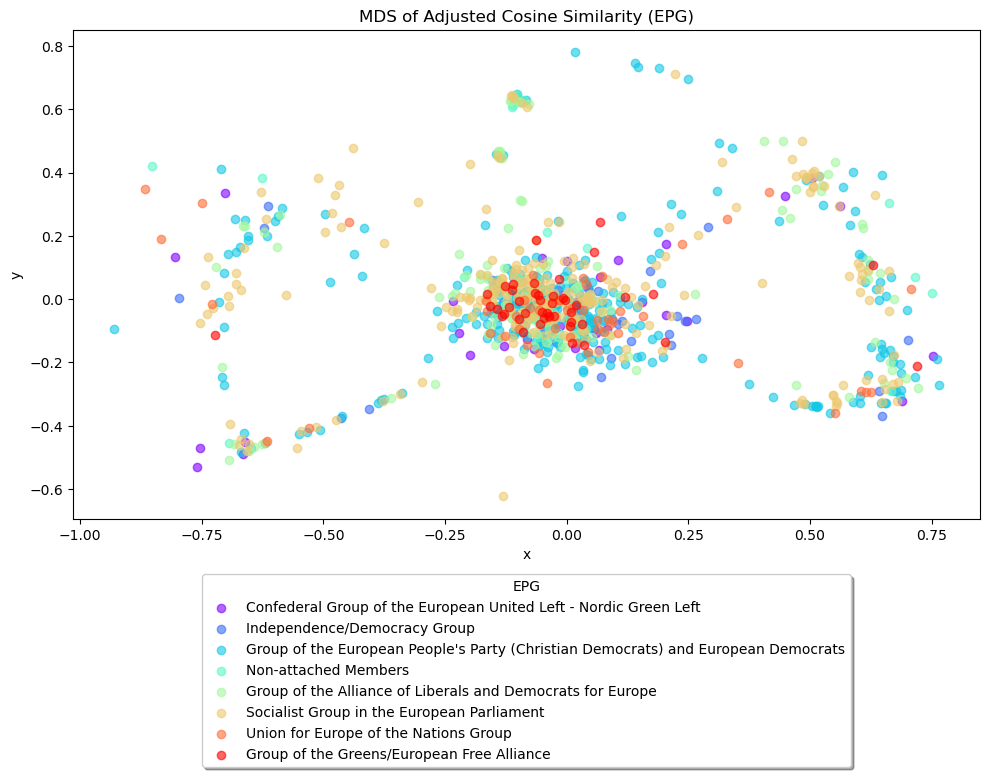

In [57]:
scatter_plot(data, mds_ACS, 'EPG', 'Adjusted Cosine Similarity')

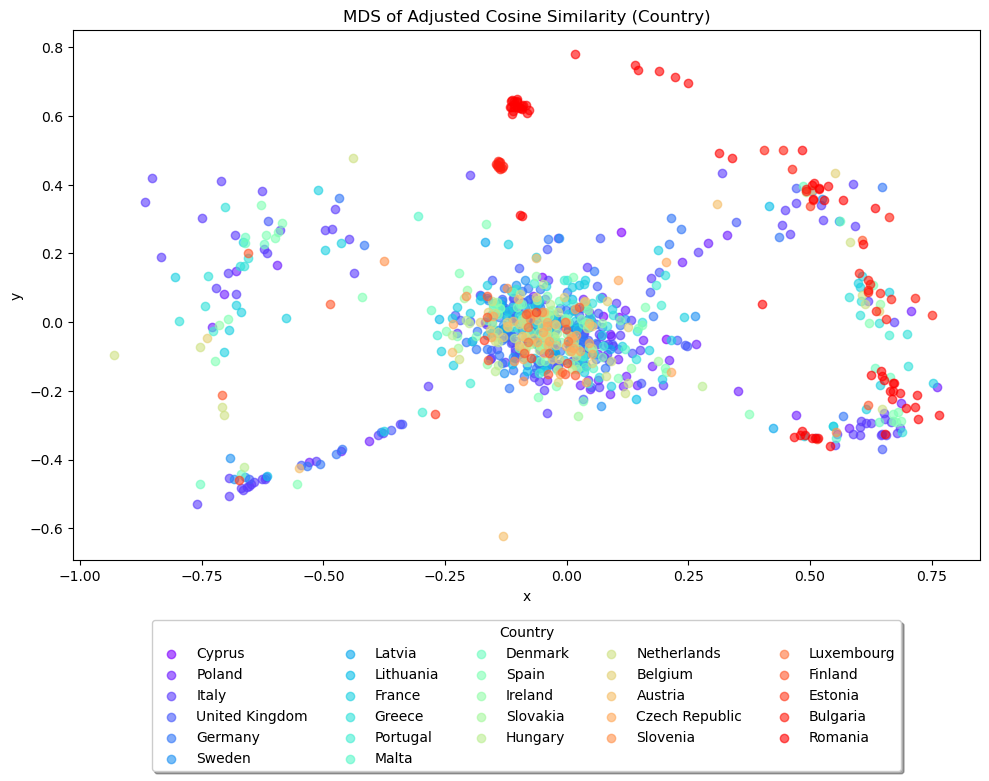

In [68]:
scatter_plot2(data, mds_ACS, 'Country', 'Adjusted Cosine Similarity')

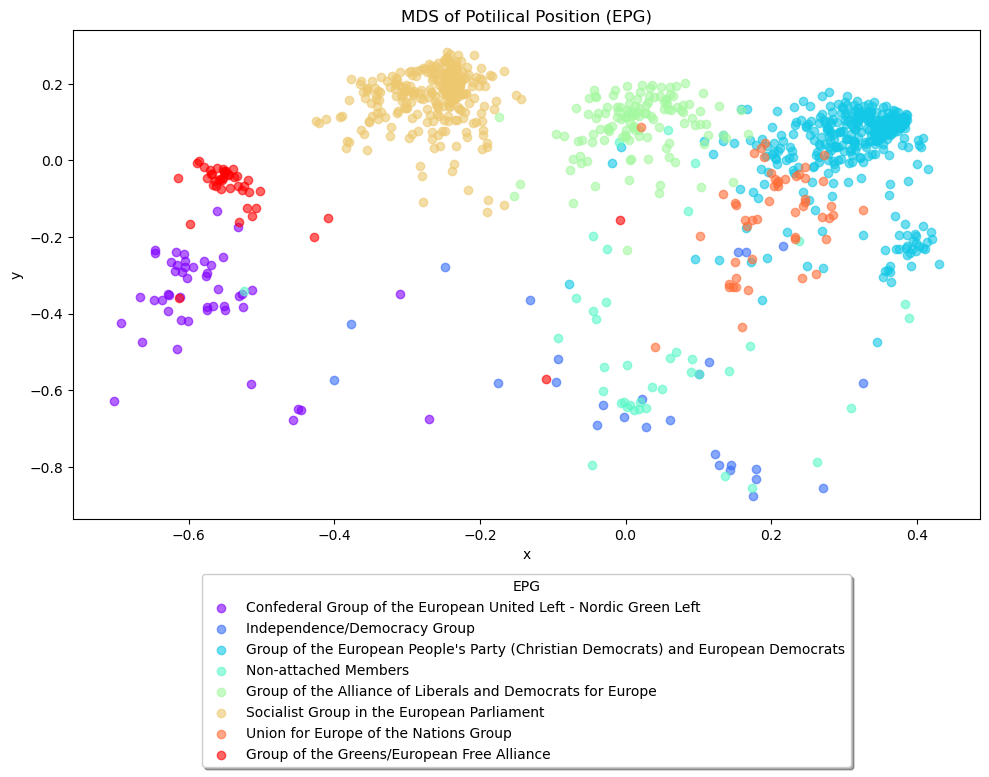

In [59]:
scatter_plot(data, mds_PP, 'EPG', 'Potilical Position')

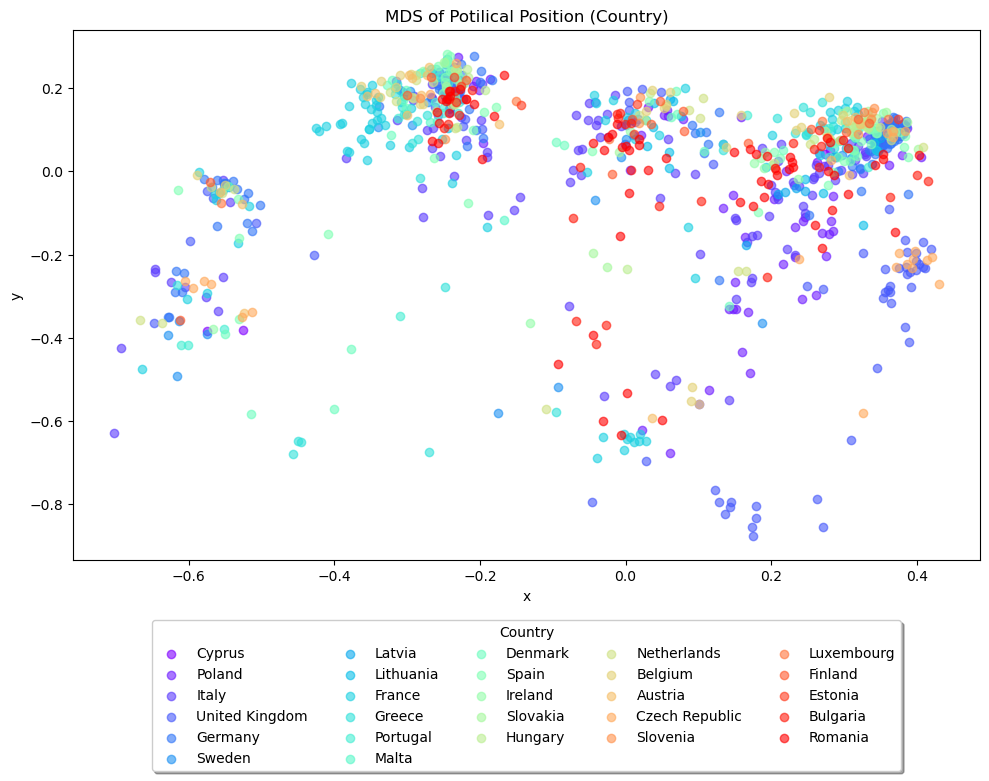

In [69]:
scatter_plot2(data, mds_PP, 'Country', 'Potilical Position')